In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c playground-series-s5e4
!unzip /content/playground-series-s5e4.zip
!rm /content/playground-series-s5e4.zip

Mounted at /content/drive
Archive:  /content/playground-series-s5e4.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
%%capture
# !pip install autogluon.tabular[all]
!pip install optuna
!pip install pytorch-tabnet
!pip install category_encoders

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.7 MB/s eta 0:00:00


## Import Packages

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,  OrdinalEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from keras_tuner import HyperModel
# from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras import layers, callbacks

from category_encoders import TargetEncoder

# from autogluon.tabular import TabularDataset, TabularPredictor
import seaborn as sns
import optuna
from scipy.stats import rankdata

from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
import torch

## Load Data

In [ ]:
train = pd.read_csv('/content/train.csv', index_col = 0)
test = pd.read_csv('/content/test.csv', index_col = 0)
sub = pd.read_csv('/content/sample_submission.csv')

In [ ]:
train.shape, test.shape, sub.shape

((750000, 11), (250000, 10), (250000, 2))

### Outlier Remove

In [ ]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]

In [ ]:
for col in train.columns:
    if col not in ['Host_Popularity_percentage', target, 'Guest_Popularity_percentage']  and pd.api.types.is_numeric_dtype(train[col]):
        Q1 = train[col].quantile(0.25)
        Q3 = train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask = (train[col] < lower_bound) | (train[col] > upper_bound)
        train.loc[mask, col] = np.nan

In [ ]:
for col in test.columns:
    if col != target not in ['Host_Popularity_percentage', target, 'Guest_Popularity_percentage'] and pd.api.types.is_numeric_dtype(test[col]):
        Q1 = test[col].quantile(0.25)
        Q3 = test[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask = (test[col] < lower_bound) | (test[col] > upper_bound)
        test.loc[mask, col] = np.nan

In [ ]:
cols_to_cap = ['Host_Popularity_percentage', 'Guest_Popularity_percentage']

for col in cols_to_cap:
    train.loc[train[col] > 100, col] = np.nan
    test.loc[test[col] > 100, col] = np.nan

In [ ]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]
numeric_cols = test.select_dtypes([int, float,bool]).columns.tolist()
categorical_cols = test.select_dtypes([object]).columns.tolist()

### Mice Impute

In [ ]:
# miss = train.isna().sum()
# mask = miss > 1
# miss_cols = miss[mask].index.tolist()

In [ ]:
# # Make copies to avoid modifying original data
# train_copy = train.copy()
# test_copy = test.copy()

# # Combine for consistent imputation
# combined = pd.concat([train_copy.drop(columns=target), test_copy], axis=0, ignore_index=True)

# # Encode categorical columns for MICE (MICE requires numeric input)
# encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
# combined[categorical_cols] = encoder.fit_transform(combined[categorical_cols])

# # Apply MICE imputation
# imputer = IterativeImputer(random_state=30)
# imputed = imputer.fit_transform(combined[numeric_cols + categorical_cols])

# # Replace original columns with imputed values
# combined_imputed = pd.DataFrame(imputed, columns=numeric_cols + categorical_cols)

# # Reconstruct train and test
# train_imputed = combined_imputed.iloc[:len(train)].copy()
# train_imputed[target] = train[target].values  # Add back target column

# test_imputed = combined_imputed.iloc[len(train):].copy()

In [ ]:
# train[miss_cols] = train_imputed[miss_cols]
# test[miss_cols] = test_imputed[miss_cols]

### Feature Engineering

In [ ]:
def feat_eng(df):
  df['ads_length'] = df['Episode_Length_minutes']*df['Number_of_Ads']
  df['sent_length'] = df['Episode_Sentiment'].map({'Neutral': 0, 'Negative': -1, 'Positive': 1}) * df['Episode_Length_minutes']
  df['genre_length'] = df['Genre'].map({'Business':3, 'Comedy':0,
                    'Education':6, 'Health':9,
                    'Lifestyle':5, 'Music':8, 'News':1, 'Sports':4,
                   'True Crime':7,   'Technology':2 }) * df['Episode_Length_minutes']
  return df


In [ ]:
train = feat_eng(train)
test = feat_eng(test)

## EDA

### Missing Value Check

In [ ]:
# Initialize a list to store data
data = []

for column in train.columns:
    data_type = str(train[column].dtype)

    # Calculate missing percentages
    train_missing = np.round(100 - train[column].count() / train.shape[0] * 100, 1)

    if column != target:
        test_missing = np.round(100 - test[column].count() / test.shape[0] * 100, 1)
        unique_values_count_test = test[column].nunique()

        # Compute unique values in train that are NOT in test
        unique_train_values = set(train[column].dropna().unique())
        unique_test_values = set(test[column].dropna().unique())
        unseen_in_test = len(unique_train_values - unique_test_values)
        unseen_percentage = np.round((unseen_in_test / len(unique_train_values)) * 100, 2) if len(unique_train_values) > 0 else 0
    else:
        test_missing = "NA"
        unique_values_count_test = "NA"
        unseen_percentage = "NA"

    # Calculate discrete nature ratio (unique values / total values)
    discrete_ratio = np.round(train[column].nunique() / train.shape[0], 4)
    unique_values_count = train[column].nunique()

    # Append row to list
    data.append([column, data_type, train_missing, test_missing,
                 discrete_ratio, unique_values_count, unique_values_count_test, unseen_percentage])

# Create a DataFrame
df_summary = pd.DataFrame(data, columns=['Feature', 'Data Type', 'Train Missing %', 'Test Missing %',
                                         'Discrete Ratio (Train)', 'Unique Values Count Train',
                                         'Unique Values Count Test', 'Unique % Unseen in Test'])

# Display the DataFrame
df_summary


,Feature,Data Type,Train Missing %,Test Missing %,Discrete Ratio (Train),Unique Values Count Train,Unique Values Count Test,Unique % Unseen in Test
0,Podcast_Name,object,0.0,0.0,0.0001,48,48,0.0
1,Episode_Title,object,0.0,0.0,0.0001,100,100,0.0
2,Episode_Length_minutes,float64,0.0,0.0,0.1325,99361,40367,88.48
3,Genre,object,0.0,0.0,0.0000,10,10,0.0
4,Host_Popularity_percentage,float64,0.0,0.0,0.0107,8045,8014,0.6
5,Publication_Day,object,0.0,0.0,0.0000,7,7,0.0
6,Publication_Time,object,0.0,0.0,0.0000,4,4,0.0
7,Guest_Popularity_percentage,float64,0.0,0.0,0.2081,156051,58794,93.63
8,Number_of_Ads,float64,0.0,0.0,0.0000,14,6,71.43
9,Episode_Sentiment,object,0.0,0.0,0.0000,3,3,0.0


### Plots

In [ ]:
 regression = train[target].nunique() > 10

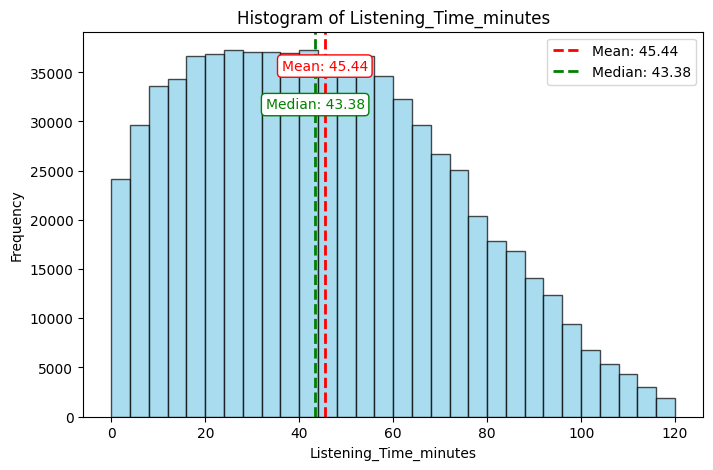

In [ ]:
# Plot based on the target type
plt.figure(figsize=(8, 5))

if regression:
    # Histogram for continuous target
    plt.hist(train[target], bins=30, edgecolor='black', alpha=0.7, color='skyblue')

    # Calculate mean and median
    mean_value = np.mean(train[target])
    median_value = np.median(train[target])

    # Add vertical lines for mean and median
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

    # Add text annotations
    plt.text(mean_value, plt.ylim()[1] * 0.9, f'Mean: {mean_value:.2f}', color='red', ha='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.3'))
    plt.text(median_value, plt.ylim()[1] * 0.8, f'Median: {median_value:.2f}', color='green', ha='center', fontsize=10, bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.3'))

    # Labels and title
    plt.xlabel(target)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {target}")
    plt.legend()

else:
    # Pie chart for categorical target
    class_counts = train[target].value_counts()
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
    plt.title(f"Distribution of {target}")

plt.show()

#### Numeric

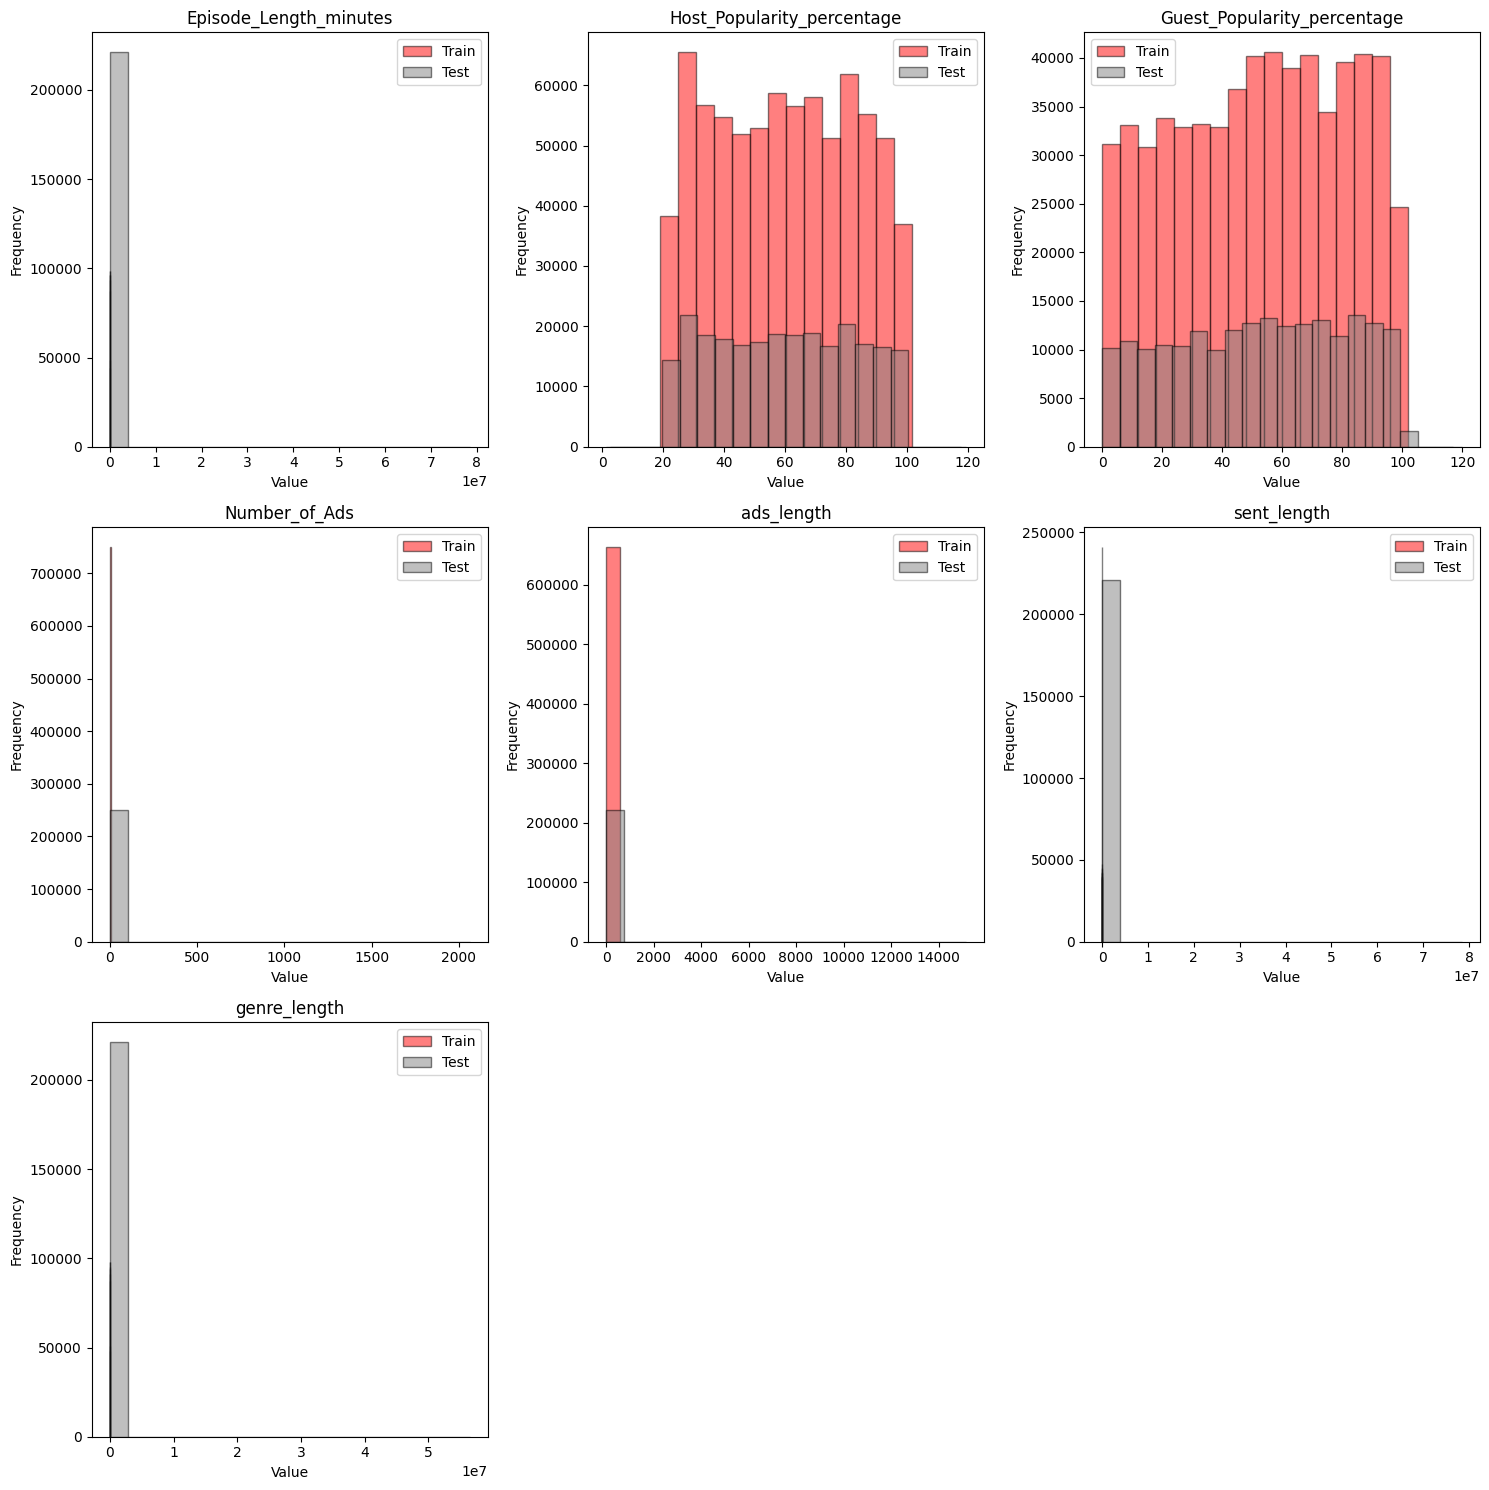

In [ ]:
# Calculate the number of rows needed for the subplots
num_rows = (len(numeric_cols) + 2) // 3

# Create subplots for each continuous column
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Loop through each continuous column and plot the histograms
for i, col in enumerate(numeric_cols):
    # Determine the range of values to plot
    max_val = max(train[col].max(), test[col].max())
    min_val = min(train[col].min(), test[col].min())
    range_val = max_val - min_val

    # Determine the bin size and number of bins
    bin_size = range_val / 20
    num_bins = round(range_val / bin_size)

    # Plot the histograms
    axs[i].hist(train[col], bins=num_bins, color='red', alpha=0.5, label='Train', edgecolor='black')
    axs[i].hist(test[col], bins=num_bins, color='grey', alpha=0.5, label='Test', edgecolor='black')

    # Titles and labels
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

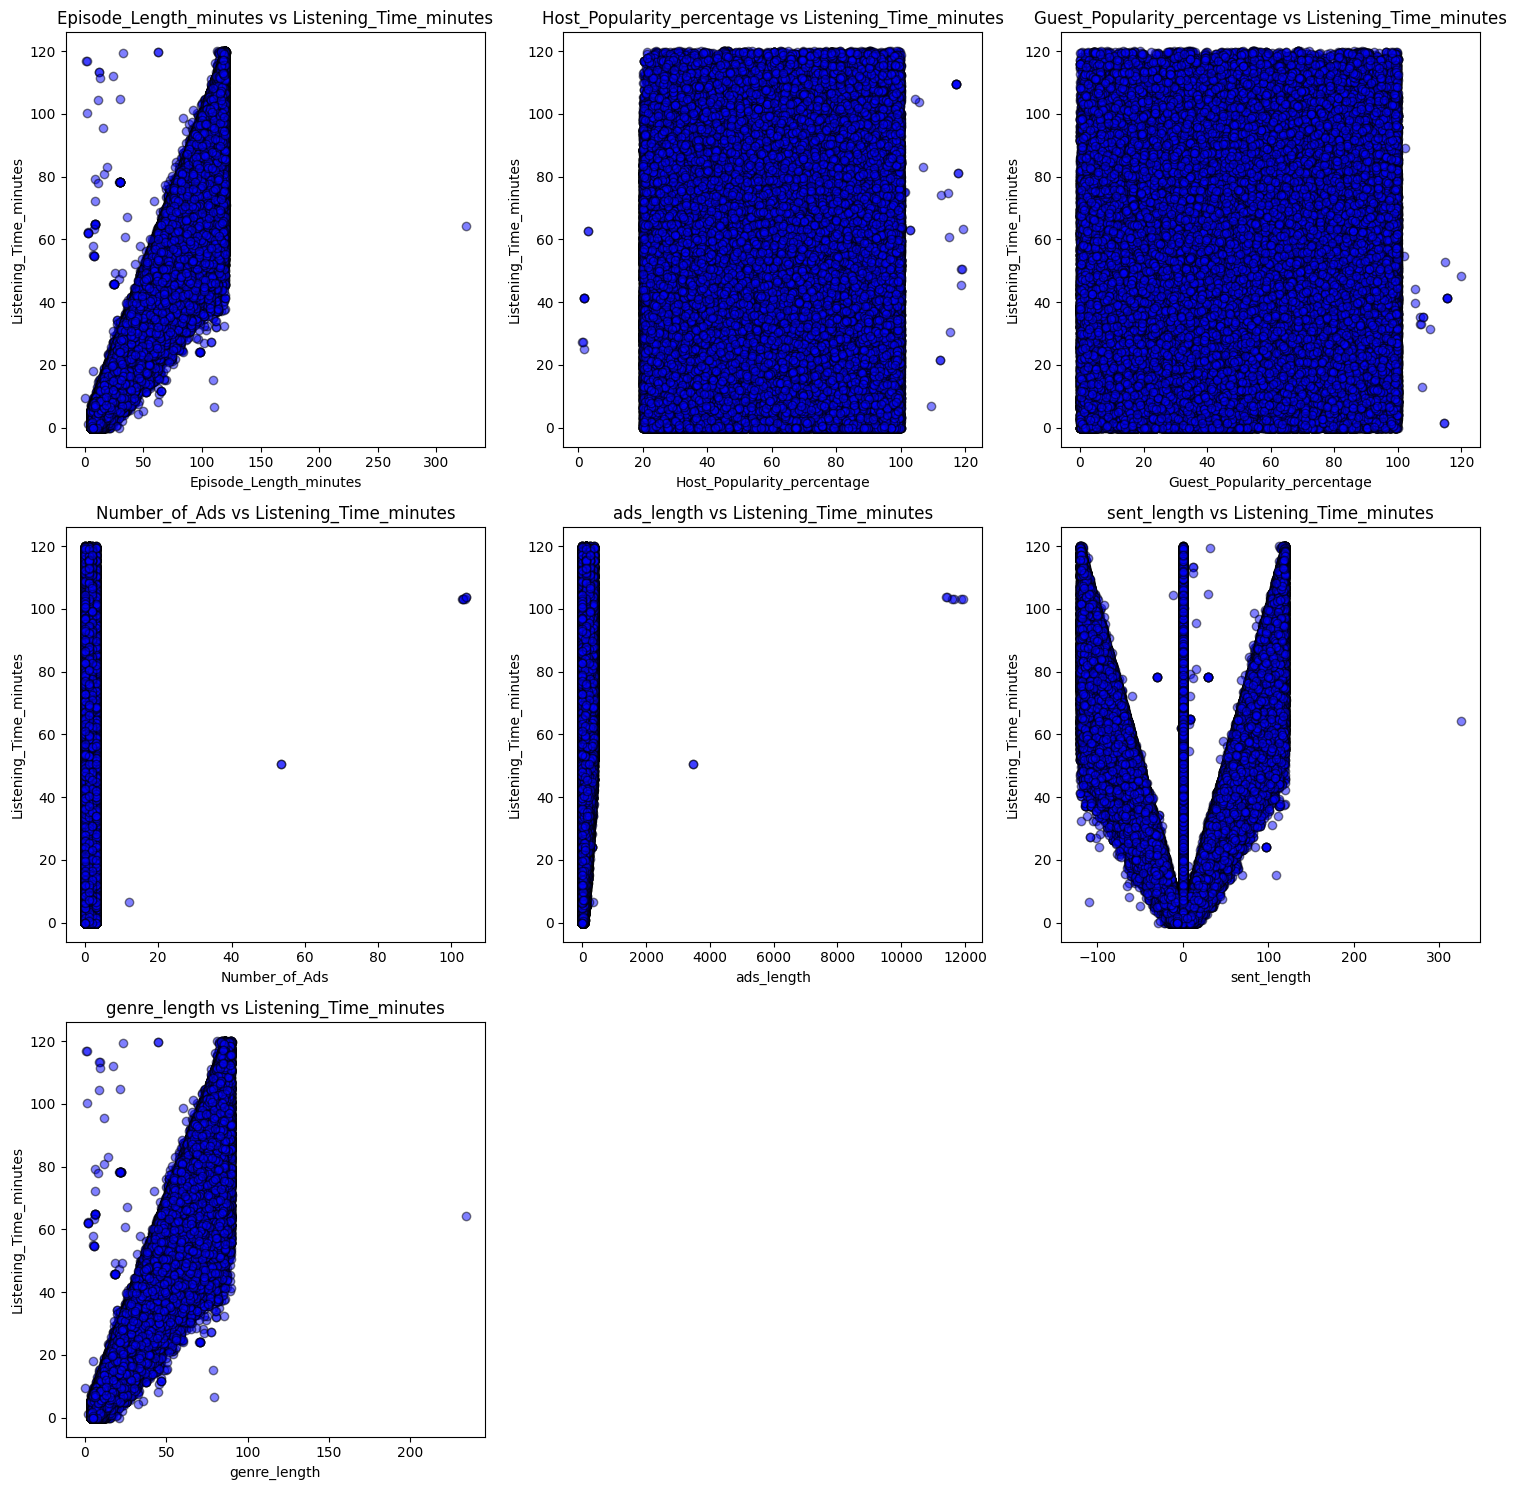

In [ ]:
if regression:
    # Determine number of rows for subplots (3 columns per row)
  num_rows = (len(numeric_cols) + 2) // 3

  # Create subplots
  fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

  # Flatten the axs array for easy iteration
  axs = axs.flatten()

  # Loop through each numeric column and plot the scatter plot
  for i, col in enumerate(numeric_cols):
      axs[i].scatter(train[col], train[target], alpha=0.5, color='blue', edgecolors='black')
      axs[i].set_title(f"{col} vs {target}")
      axs[i].set_xlabel(col)
      axs[i].set_ylabel(target)

  # Remove any unused subplots
  for j in range(i + 1, len(axs)):
      fig.delaxes(axs[j])

  plt.tight_layout()
  plt.show()

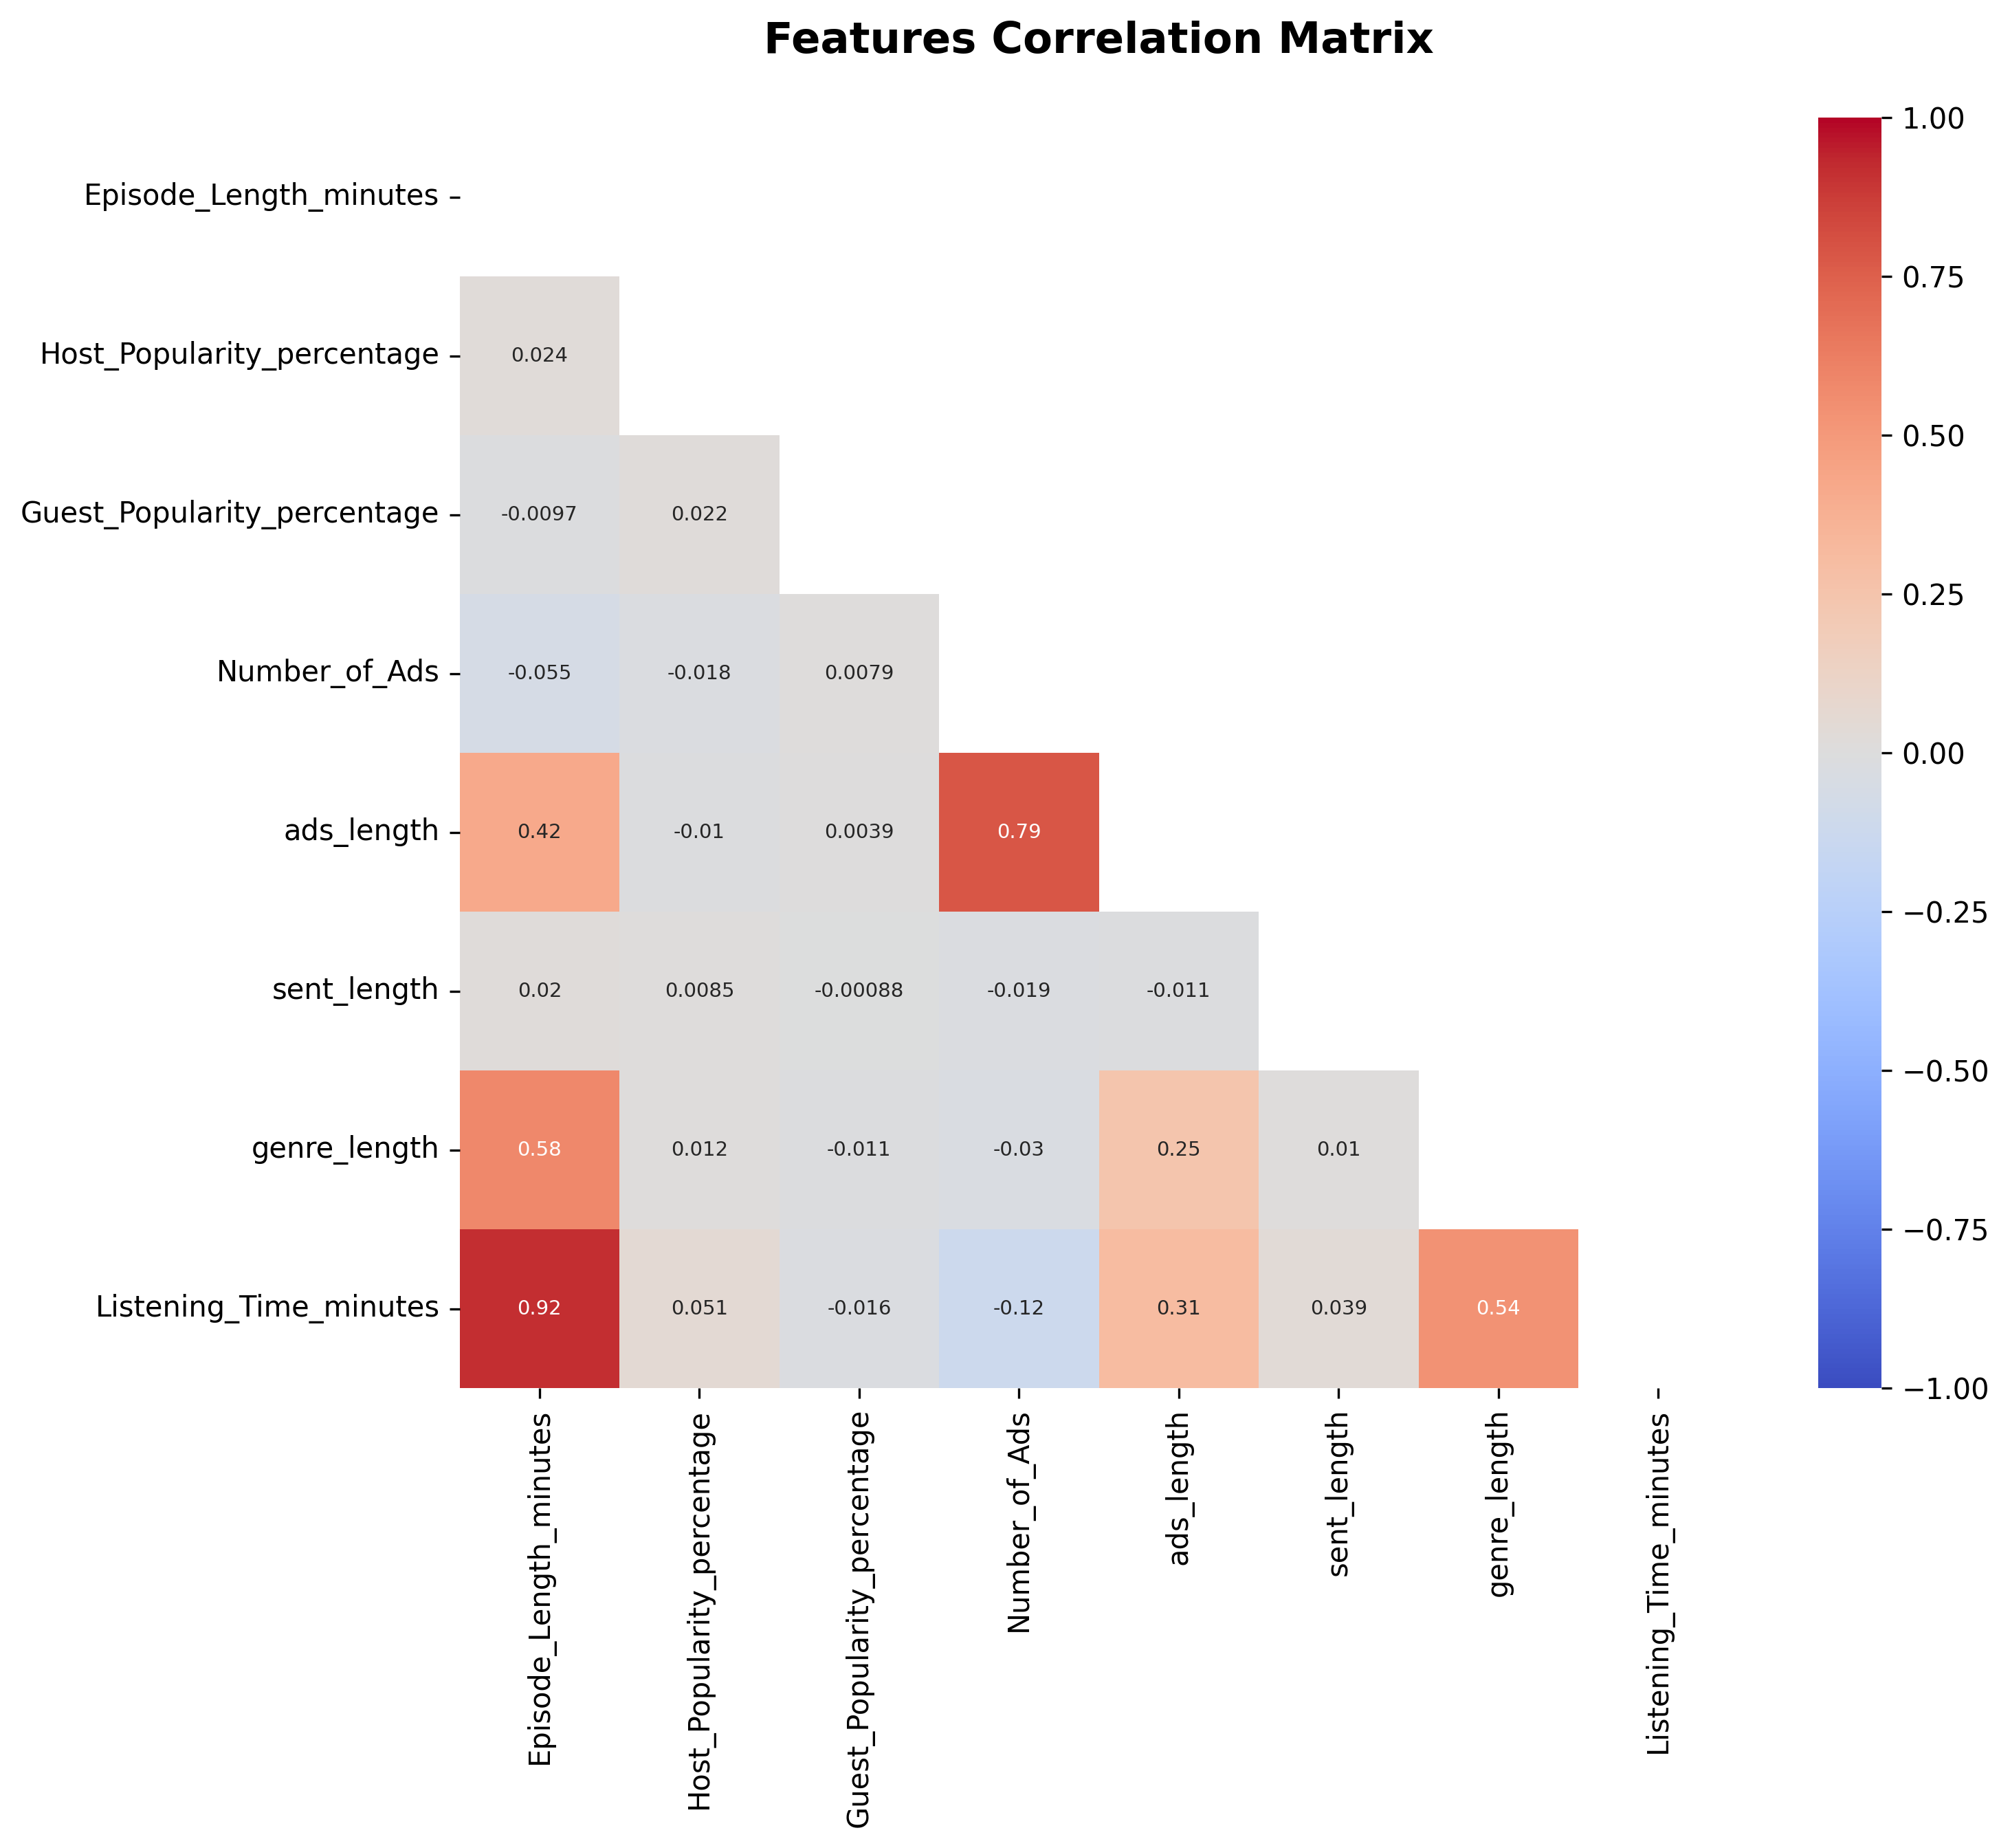

In [ ]:
corr = train[numeric_cols + [target]].corr()
plt.figure(figsize = (10, 8), dpi = 300)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, cmap = 'coolwarm', annot = True, annot_kws = {'size' : 7}, vmin = -1, vmax = 1)
plt.title('Features Correlation Matrix\n', fontsize = 15, weight = 'bold')
plt.show()

#### Categorical

<ipython-input-31-1e965445f012>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[i].boxplot(
<ipython-input-31-1e965445f012>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[i].boxplot(
<ipython-input-31-1e965445f012>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[i].boxplot(
<ipython-input-31-1e965445f012>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[i].boxplot(
<ipython-input-31-1e965445f012>:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has be

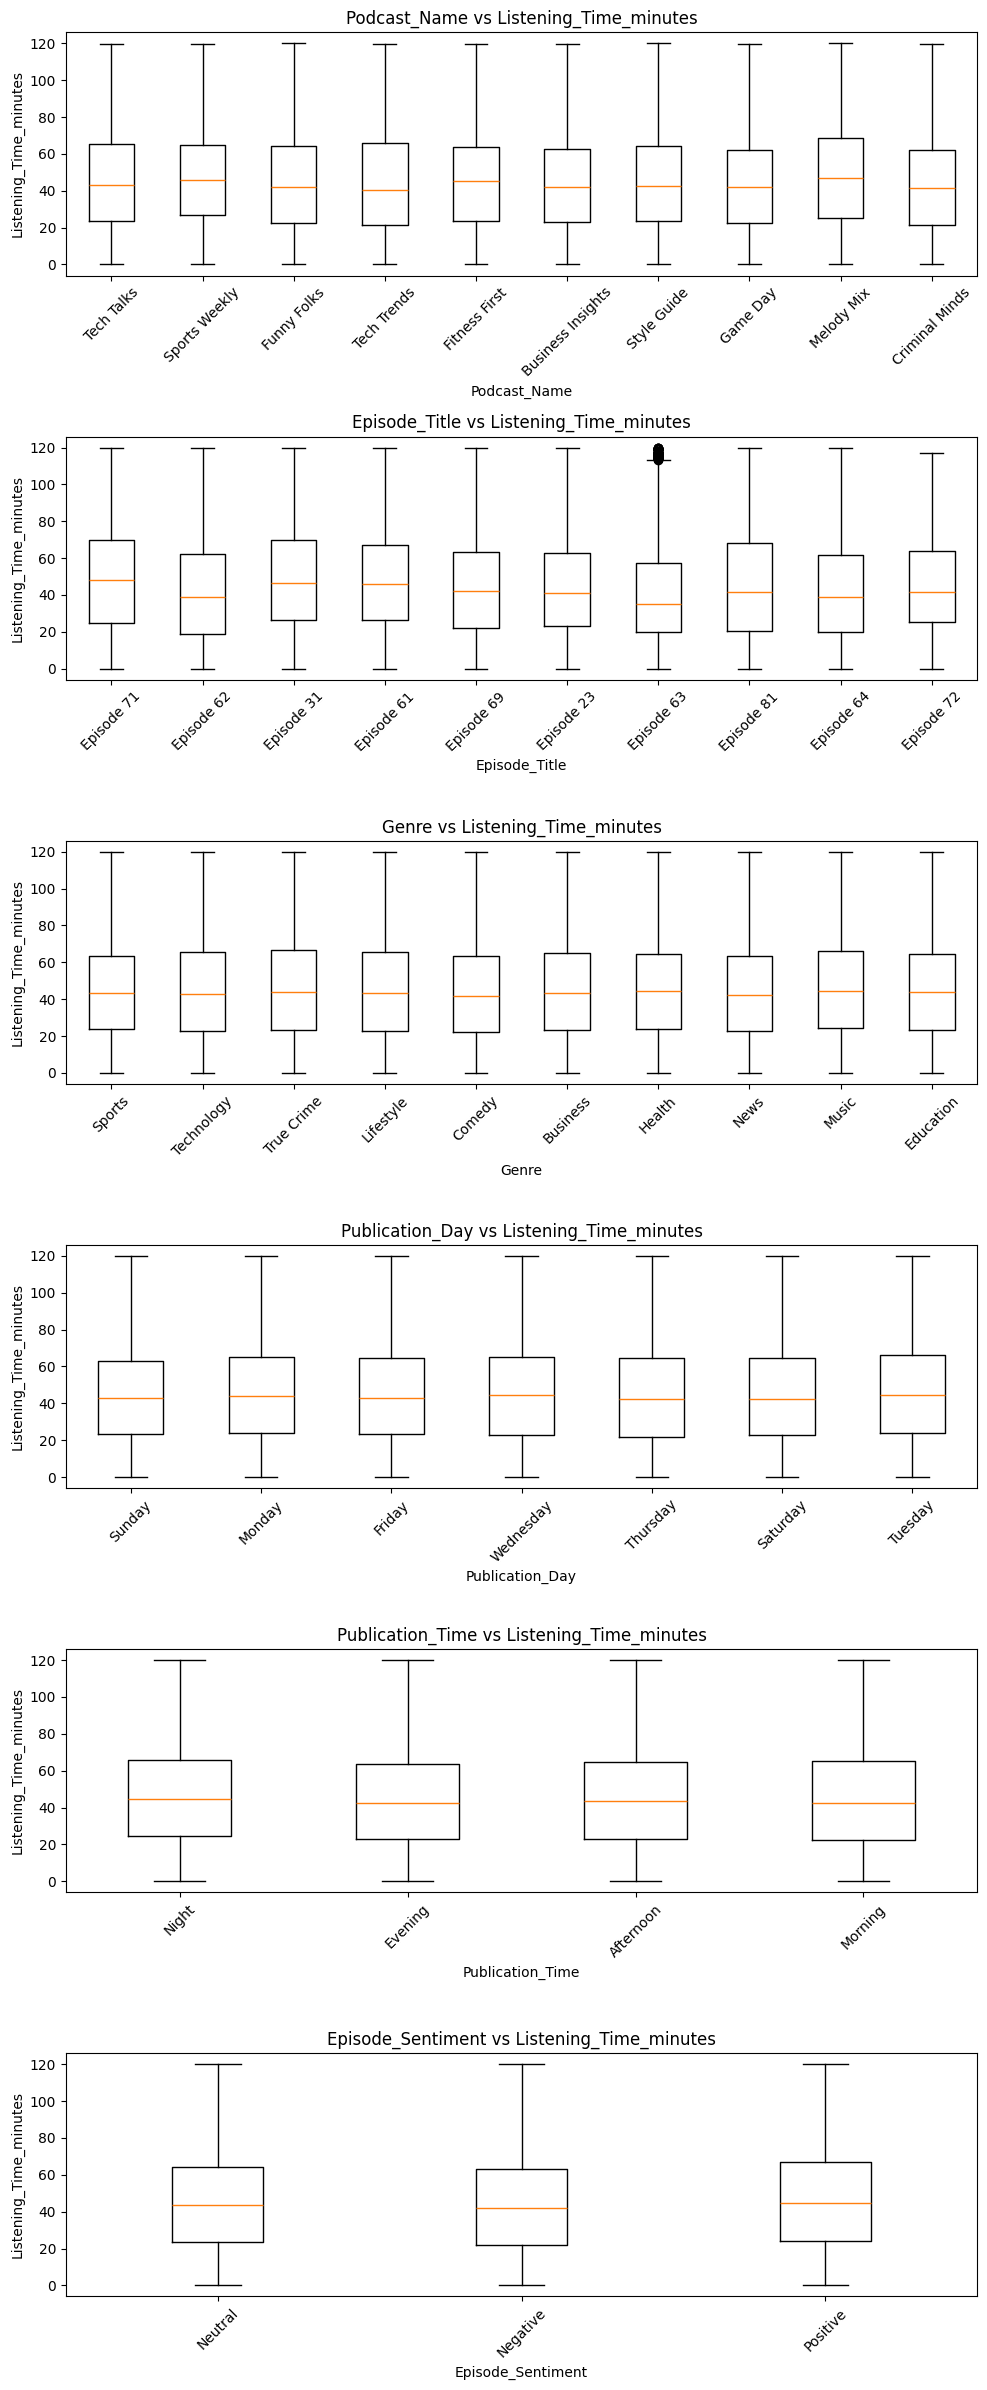

In [ ]:
if regression:
  fig, axs = plt.subplots(len(categorical_cols), 1, figsize=(10, len(categorical_cols) * 4))

  for i, col in enumerate(categorical_cols):
      # Get the top 10 most frequent categories
      top_categories = train[col].value_counts().nlargest(10).index

      # Filter train data to only include top categories
      filtered_train = train[train[col].isin(top_categories)]

      # Create box plot
      axs[i].boxplot(
          [filtered_train[filtered_train[col] == category][target] for category in top_categories],
          labels=top_categories
      )

      axs[i].set_title(f"{col} vs {target}")
      axs[i].set_xlabel(col)
      axs[i].set_ylabel(target)
      axs[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

  plt.tight_layout()
  plt.show()

In [ ]:
if regression:
  from scipy.stats import kruskal

  kruskal_results = {}

  for col in categorical_cols:
      groups = [train[train[col] == category][target] for category in train[col].unique()]
      if len(groups) > 1:
          stat, p = kruskal(*groups)
          kruskal_results[col] = {"Kruskal-Wallis Statistic": stat, "p-value": p}

  # Convert to DataFrame
  kruskal_df = pd.DataFrame.from_dict(kruskal_results, orient="index")
  display(kruskal_df.sort_values(by="Kruskal-Wallis Statistic", ascending=False))

# Higher statistic → Stronger categorical effect

# Lower p-value → More significant relationship

,Kruskal-Wallis Statistic,p-value
Episode_Title,4586.367289,0.000000e+00
Podcast_Name,1922.869707,0.000000e+00
Episode_Sentiment,1041.456446,7.089348e-227
Publication_Time,497.498483,1.662583e-107
Genre,362.838677,1.144837e-72
Publication_Day,339.245154,3.139848e-70


### Unique

In [ ]:
for i in categorical_cols:
  display(train[i].value_counts())
  display(test[i].value_counts())

,count
Podcast_Name,
Tech Talks,22847
Sports Weekly,20053
Funny Folks,19635
Tech Trends,19549
Fitness First,19488
Business Insights,19480
Style Guide,19364
Game Day,19272
Melody Mix,18889


,count
Podcast_Name,
Tech Talks,7553
Sports Weekly,6633
Funny Folks,6621
Fitness First,6543
Style Guide,6469
Business Insights,6448
Tech Trends,6446
Melody Mix,6357
Game Day,6345


,count
Episode_Title,
Episode 71,10515
Episode 62,10373
Episode 31,10292
Episode 61,9991
Episode 69,9864
...,...
Episode 2,5134
Episode 25,5117
Episode 41,4965


,count
Episode_Title,
Episode 71,3492
Episode 31,3439
Episode 62,3438
Episode 61,3417
Episode 81,3358
...,...
Episode 25,1796
Episode 41,1730
Episode 2,1697


,count
Genre,
Sports,87606
Technology,86256
True Crime,85059
Lifestyle,82461
Comedy,81453
Business,80521
Health,71416
News,63385
Music,62743


,count
Genre,
Sports,28903
Technology,28397
True Crime,28381
Lifestyle,27679
Comedy,27296
Business,26690
Health,23926
News,21250
Music,21054


,count
Publication_Day,
Sunday,115946
Monday,111963
Friday,108237
Wednesday,107886
Thursday,104360
Saturday,103505
Tuesday,98103


,count
Publication_Day,
Sunday,38906
Monday,37344
Friday,35844
Wednesday,35724
Thursday,34798
Saturday,34607
Tuesday,32777


,count
Publication_Time,
Night,196849
Evening,195778
Afternoon,179460
Morning,177913


,count
Publication_Time,
Night,65440
Evening,65247
Afternoon,59765
Morning,59548


,count
Episode_Sentiment,
Neutral,251291
Negative,250116
Positive,248593


,count
Episode_Sentiment,
Neutral,83671
Negative,83510
Positive,82819


In [ ]:
train[numeric_cols].describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
count,662907.000000,750000.000000,603970.000000,749999.000000
mean,64.504738,59.859901,52.236449,1.348855
std,32.969603,22.873098,28.451241,1.151130
min,0.000000,1.300000,0.000000,0.000000
25%,35.730000,39.410000,28.380000,0.000000
50%,63.840000,60.050000,53.580000,1.000000
75%,94.070000,79.530000,76.600000,2.000000
max,325.240000,119.460000,119.910000,103.910000


In [ ]:
test[test['Number_of_Ads'] > 3]

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
id,,,,,,,,,,
787939,Life Lessons,Episode 94,89.84,Lifestyle,60.79,Sunday,Afternoon,62.13,89.12,Neutral
928393,Tech Trends,Episode 59,7.15,Technology,71.90,Sunday,Morning,17.39,2063.00,Positive


In [ ]:
test[numeric_cols].describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
count,2.212640e+05,250000.000000,201168.000000,250000.000000
mean,4.192987e+02,59.716491,52.192796,1.355852
std,1.668545e+05,22.880028,28.445034,4.274399
min,2.470000e+00,2.490000,0.000000,0.000000
25%,3.578000e+01,39.250000,28.320000,0.000000
50%,6.397000e+01,59.900000,53.360000,1.000000
75%,9.415000e+01,79.390000,76.560000,2.000000
max,7.848626e+07,117.760000,116.820000,2063.000000


## HGBG

In [ ]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]
X = train.drop(columns=[target])  # Features
y = train[target]  # Target

X[categorical_cols] = X[categorical_cols].astype('category')

n_splits = 5
# skf = StratifiedKFold(n_splits=n_splits, shuffle=False)#, random_state=30)
# n_splits = train.shape[0] // 365  # Ensure total_rows is defined
kf = KFold(n_splits=n_splits, shuffle=True, random_state=30)

In [ ]:
# # Define Preprocessing
# preprocessor = ColumnTransformer(transformers=[
#     ('num', Pipeline([
#         ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
#         ('scaler', StandardScaler())  # Scale numerical features
#     ]), numeric_cols),

#     ('cat', Pipeline([
#         ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
#         # ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Encode categories
#         ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
#     ]), categorical_cols)
# ])

# # Define HistGradientBoosting parameters
# hgb_params = {'learning_rate': 0.03700810048803804, 'max_iter': 479,
#               'max_leaf_nodes': 42, 'max_depth': 15, 'min_samples_leaf': 7,
#               'l2_regularization': 0.31078511294032274, 'max_features': 0.9294055352549158,
#               'max_bins': 108, 'validation_fraction': 0.20658943700365168,
#               'n_iter_no_change': 16, 'tol': 2.9974375065744247e-07,'random_state': 30}


# # Define full pipeline
# hbgb_pipeline = Pipeline([
#     ('preprocessor', preprocessor),  # Preprocess data
#     ('model', HistGradientBoostingRegressor( **hgb_params))  # Train model
# ])

# # Store out-of-fold (OOF) predictions
# oof_preds = np.zeros(len(train))
# hgb_fold_scores = []

# # K-Fold Cross-Validation for Regression
# for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
#     print(f"Training fold {fold+1}...")

#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     # Fit pipeline
#     hbgb_pipeline.fit(X_train, y_train)

#     # Predict continuous values
#     fold_pred = hbgb_pipeline.predict(X_val)
#     oof_preds[val_idx] = fold_pred

#     # Compute RMSE for the fold
#     fold_rmse = root_mean_squared_error(y_val, fold_pred)
#     hgb_fold_scores.append(fold_rmse)
#     print(f"Fold {fold+1} RMSE: {fold_rmse:.4f}")

# # Compute overall RMSE
# overall_rmse = root_mean_squared_error(y, oof_preds)
# print("\nFold RMSE Scores:", hgb_fold_scores)
# print(f"Overall RMSE Score: {overall_rmse:.4f}")

Training fold 1...
Fold 1 RMSE: 13.0409
Training fold 2...
Fold 2 RMSE: 13.0897
Training fold 3...
Fold 3 RMSE: 13.0107
Training fold 4...
Fold 4 RMSE: 13.1399
Training fold 5...
Fold 5 RMSE: 13.0625

Fold RMSE Scores: [13.040864184157398, 13.089653496826433, 13.010712654065149, 13.139864674053843, 13.062535291987945]
Overall RMSE Score: 13.0688


In [ ]:
13.3687 # oridinal encoding?
13.0779 # no feat eng
13.0688 # feat eng small
13.0674 # target encode

In [ ]:
# Store OOF predictions
oof_preds = np.zeros(len(train))
hgb_fold_scores = []

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=30)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold+1}...")

    X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Separate numeric and categorical preprocessing
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Target Encoder for categorical columns (fit only on training fold)
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X_train_cat = cat_imputer.fit_transform(X_train[categorical_cols])
    X_val_cat = cat_imputer.transform(X_val[categorical_cols])

    target_encoder = TargetEncoder()
    X_train_cat_encoded = target_encoder.fit_transform(X_train_cat, y_train)
    X_val_cat_encoded = target_encoder.transform(X_val_cat)

    # Impute and scale numeric columns
    X_train_num = num_pipeline.fit_transform(X_train[numeric_cols])
    X_val_num = num_pipeline.transform(X_val[numeric_cols])

    # Concatenate numeric and encoded categorical features
    X_train_processed = np.hstack([X_train_num, X_train_cat_encoded])
    X_val_processed = np.hstack([X_val_num, X_val_cat_encoded])

    # Train model
    hgb_model = HistGradientBoostingRegressor(**hgb_params)
    hgb_model.fit(X_train_processed, y_train)

    # Predict
    fold_pred = hgb_model.predict(X_val_processed)
    oof_preds[val_idx] = fold_pred

    # Score
    fold_rmse = root_mean_squared_error(y_val, fold_pred)
    hgb_fold_scores.append(fold_rmse)
    print(f"Fold {fold+1} RMSE: {fold_rmse:.4f}")

# Final score
overall_rmse = root_mean_squared_error(y, oof_preds)
print("\nFold RMSE Scores:", hgb_fold_scores)
print(f"Overall RMSE Score: {overall_rmse:.4f}")

ModuleNotFoundError: No module named 'category_encoders'

In [ ]:
# test[categorical_cols] = test[categorical_cols].astype('category')
# hgb_pred = hbgb_pipeline.predict(test[list(X.columns)])
# sub[target] = hgb_pred
# sub.to_csv('/content/drive/MyDrive/Output/sub.csv', index = False)

In [ ]:
# Impute categorical columns (use same strategy as training)
cat_imputer = SimpleImputer(strategy='most_frequent')
test_cat_imputed = cat_imputer.fit_transform(test[categorical_cols])  # or use .transform(...) if you've saved the imputer

# Apply target encoding (IMPORTANT: use the encoder fitted on training data)
test_cat_encoded = target_encoder.transform(test_cat_imputed)  # `target_encoder` must be the one fitted during training

# Impute + scale numeric features
test_num = num_pipeline.transform(test[numeric_cols])  # same `num_pipeline` used in training

# Combine numeric and categorical features
test_processed = np.hstack([test_num, test_cat_encoded])

# Make predictions
hgb_pred = hgb_model.predict(test_processed)  # use trained model from training

# Save submission
sub[target] = hgb_pred
sub.to_csv('/content/drive/MyDrive/Output/sub.csv', index=False)

In [ ]:
sub

,id,Listening_Time_minutes
0,750000,55.757416
1,750001,17.639823
2,750002,49.244308
3,750003,80.343665
4,750004,49.296277
...,...,...
249995,999995,11.999854
249996,999996,58.350862
249997,999997,6.878232
249998,999998,74.085842


In [ ]:
# Submit
!kaggle competitions submit -c playground-series-s5e4 -f /content/drive/MyDrive/Output/sub.csv -m "hgbg cat encode"

100% 6.01M/6.01M [00:00<00:00, 12.9MB/s]
Successfully submitted to Predict Podcast Listening Time

### Hyp Tune

In [ ]:
def objective(trial):
    params = {
        'loss': 'squared_error',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 10.0),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'max_bins': trial.suggest_int('max_bins', 50, 255),
        'early_stopping': 'auto',
        'scoring': 'loss',
        'validation_fraction': trial.suggest_float('validation_fraction', 0.05, 0.3),
        'n_iter_no_change': trial.suggest_int('n_iter_no_change', 5, 20),
        'tol': trial.suggest_float('tol', 1e-8, 1e-5, log=True),
        'random_state': 30
    }

    # Define updated preprocessor with TargetEncoder
    preprocessor = ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_cols),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder())
        ]), categorical_cols)
    ])

    # Full pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', HistGradientBoostingRegressor(**params))
    ])

    # Evaluate with cross-validation
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return np.mean(scores)

# Run Optuna study
study = optuna.create_study(direction="maximize")  # Maximize AUC Score
study.optimize(objective, n_trials=50, n_jobs=-1)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)

[I 2025-04-07 15:23:40,500] A new study created in memory with name: no-name-fd86e617-96ab-4dbb-a4f8-cc991e0715d6
[I 2025-04-07 15:58:42,751] Trial 0 finished with value: -13.085857306961568 and parameters: {'learning_rate': 0.18579622124239867, 'max_iter': 753, 'max_leaf_nodes': 23, 'max_depth': 3, 'min_samples_leaf': 15, 'l2_regularization': 9.024113612673846, 'max_features': 0.8723232215180559, 'max_bins': 244, 'validation_fraction': 0.08787054739467152, 'n_iter_no_change': 8, 'tol': 2.2698077789262264e-07}. Best is trial 0 with value: -13.085857306961568.
[I 2025-04-07 16:00:15,446] Trial 1 finished with value: -13.166512568379764 and parameters: {'learning_rate': 0.016021985680717263, 'max_iter': 469, 'max_leaf_nodes': 16, 'max_depth': 11, 'min_samples_leaf': 27, 'l2_regularization': 5.463524733889026, 'max_features': 0.6904627254137496, 'max_bins': 71, 'validation_fraction': 0.22095844405754156, 'n_iter_no_change': 16, 'tol': 4.593103233536112e-08}. Best is trial 1 with value: -1

In [ ]:
print("Best Hyperparameters:", study.best_params)

In [ ]:
categorical_cols

['Podcast_Name',
 'Episode_Title',
 'Genre',
 'Publication_Day',
 'Publication_Time',
 'Episode_Sentiment']

## XGboost

In [ ]:
target = list(set(train.columns.tolist()) - set(test.columns.tolist()))[0]
X = train.drop(columns=[target])  # Features
y = train[target]  # Target

X[categorical_cols] = X[categorical_cols].astype('category')

n_splits = 5
# skf = StratifiedKFold(n_splits=n_splits, shuffle=False)#, random_state=30)
# n_splits = train.shape[0] // 365  # Ensure total_rows is defined
kf = KFold(n_splits=n_splits, shuffle=True)

In [ ]:
# Store out-of-fold (OOF) predictions and fold scores
oof_preds = np.zeros(len(train))
xgb_fold_scores = []

# XGBoost parameters
xgb_params = {'learning_rate': 0.02067377508451852, 'max_depth': 10,
               'subsample': 0.7769677792116577, 'colsample_bytree': 0.6773856266450066,
               'n_estimators': 805,
               'reg_alpha': 0.12642423074372283, 'reg_lambda': 1.3633397659742029e-05,
    "random_state": 30
}

features_used = list(X.columns)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold+1}...")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    xgb_model = xgb.XGBRegressor(**xgb_params, enable_categorical=True)
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    fold_pred = xgb_model.predict(X_val)
    oof_preds[val_idx] = fold_pred

    # Compute AUC for the fold
    fold_auc = root_mean_squared_error(y_val, fold_pred)
    xgb_fold_scores.append(fold_auc)
    print(f"Fold {fold+1} SCORE: {fold_auc:.4f}")

# Compute overall AUC score
overall_auc = root_mean_squared_error(y, oof_preds)
print("\nFold Scores:", xgb_fold_scores)
print(f"Overall Score: {overall_auc:.4f}")

Training fold 1...
Fold 1 SCORE: 12.8096
Training fold 2...
Fold 2 SCORE: 12.8030
Training fold 3...
Fold 3 SCORE: 12.7280
Training fold 4...
Fold 4 SCORE: 12.7811
Training fold 5...
Fold 5 SCORE: 12.7950

Fold Scores: [12.809574886315644, 12.803005962651186, 12.727952814575634, 12.781090121080451, 12.79496269245366]
Overall Score: 12.7834


In [ ]:
# Fit model on full training data
xgb_model = xgb.XGBRegressor(**xgb_params, enable_categorical=True)
xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6773856266450066, device=None,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02067377508451852, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=805, n_jobs=None,
             num_parallel_tree=None, random_state=30, ...)

In [ ]:
12.7934 # optuna
12.7823 # feat eng
12.8357 # target encode
12.7778 # remove outliers
12.8327 # mice impute

In [ ]:
test[categorical_cols] = test[categorical_cols].astype('category')
xgb_pred = xgb_model.predict(test[list(X.columns)])
sub[target] = xgb_pred
sub.to_csv('/content/drive/MyDrive/Output/sub.csv', index = False)

In [ ]:
# Store out-of-fold (OOF) predictions and fold scores
oof_preds = np.zeros(len(train))
xgb_fold_scores = []

# XGBoost parameters
xgb_params = {'learning_rate': 0.02067377508451852, 'max_depth': 10,
              'subsample': 0.7769677792116577, 'colsample_bytree': 0.6773856266450066,
              'n_estimators': 805,
              'reg_alpha': 0.12642423074372283, 'reg_lambda': 1.3633397659742029e-05,
              'random_state': 30}

features_used = list(X.columns)
te_encode_cols = ['Podcast_Name', 'Episode_Title']

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold+1}...")

    X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Target encoding: fit on train only, transform train and val
    te = TargetEncoder(cols=te_encode_cols)
    X_train[te_encode_cols] = te.fit_transform(X_train[te_encode_cols], y_train)
    X_val[te_encode_cols] = te.transform(X_val[te_encode_cols])

    # Fit model
    xgb_model = xgb.XGBRegressor(**xgb_params, enable_categorical=True)
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Predict and score
    fold_pred = xgb_model.predict(X_val)
    oof_preds[val_idx] = fold_pred

    fold_rmse = root_mean_squared_error(y_val, fold_pred)
    xgb_fold_scores.append(fold_rmse)
    print(f"Fold {fold+1} RMSE: {fold_rmse:.4f}")

# Compute overall RMSE
overall_rmse = root_mean_squared_error(y, oof_preds)
print("\nFold RMSE Scores:", xgb_fold_scores)
print(f"Overall RMSE Score: {overall_rmse:.4f}")

Training fold 1...
Fold 1 RMSE: 12.8332
Training fold 2...
Fold 2 RMSE: 12.7538
Training fold 3...
Fold 3 RMSE: 12.7843
Training fold 4...
Fold 4 RMSE: 12.8645
Training fold 5...
Fold 5 RMSE: 12.8655

Fold RMSE Scores: [12.833191858466554, 12.753823136434319, 12.784260339555301, 12.86445751501081, 12.86550356250269]
Overall RMSE Score: 12.8203


In [ ]:
# Fit TargetEncoder on full training data
te = TargetEncoder(cols=te_encode_cols)
X_encoded = X.copy()
X_encoded[te_encode_cols] = te.fit_transform(X_encoded[te_encode_cols], y)

# Apply the same transformation to the test data
test_encoded = test.copy()
test_encoded[te_encode_cols] = te.transform(test_encoded[te_encode_cols])

# Fit model on full training data
xgb_model = xgb.XGBRegressor(**xgb_params, enable_categorical=True)
xgb_model.fit(X_encoded, y)



ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Genre: object, Publication_Day: object, Publication_Time: object, Episode_Sentiment: object

In [ ]:
test_encoded[categorical_cols] = test_encoded[categorical_cols].astype('category')

# Predict on test set
xgb_pred = xgb_model.predict(test_encoded[list(X_encoded.columns)])

# Save submission
sub[target] = xgb_pred
sub.to_csv('/content/drive/MyDrive/Output/sub.csv', index=False)

In [ ]:
sub.head()

,id,Listening_Time_minutes
0,750000,53.968815
1,750001,18.711702
2,750002,51.961231
3,750003,81.977379
4,750004,44.526299


In [ ]:
# Submit
!kaggle competitions submit -c playground-series-s5e4 -f /content/drive/MyDrive/Output/sub.csv -m "xgb full add outlier remove te encode"

100% 3.94M/3.94M [00:00<00:00, 5.76MB/s]
Successfully submitted to Predict Podcast Listening Time

### Hyp Tune

In [ ]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-5, 10.0),
        "random_state": 30,
        "use_label_encoder": False
    }

    n_splits = 5  # Ensure total_rows is defined
    kf = KFold(n_splits=n_splits, shuffle=True)  # Adjust shuffle if needed
    oof_preds = np.zeros(len(y))


    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = xgb.XGBRegressor(**params, enable_categorical=True)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        fold_pred = model.predict(X_val)
        oof_preds[val_idx] = fold_pred

    return root_mean_squared_error(y, oof_preds)

# Run Optuna hyperparameter optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Get best hyperparameters
best_params = study.best_params

[I 2025-04-21 20:34:11,689] A new study created in memory with name: no-name-5e2c5754-1640-4383-8a74-e88356742f29
<ipython-input-75-0f5de6d8366f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-75-0f5de6d8366f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 10.0),
<ipython-input-75-0f5de6d8366f>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.sug

In [ ]:
print("\nBest Hyperparameters:", best_params)

## TF Model

In [ ]:
# X = train.drop(columns=[target])  # Features
# y = train[target]  # Target

# # Define Preprocessing
# preprocessor = ColumnTransformer(transformers=[
#     ('num', Pipeline([
#         ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
#         ('scaler', StandardScaler())  # Scale numerical features
#     ]), numeric_cols),

#     ('cat', Pipeline([
#         ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
#         # ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Encode categories
#         ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
#     ]), categorical_cols)
# ])

# X_processed = preprocessor.fit_transform(X)

In [ ]:
# def build_model():
#     model = keras.Sequential([
#         layers.Input(shape=(X_processed.shape[1],)),
#         layers.Dense(128, activation="relu"),
#         layers.Dropout(0.3),
#         layers.Dense(64, activation="relu"),
#         layers.Dropout(0.2),
#         layers.Dense(1, activation="linear")  # Binary classification
#     ])

#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=0.001),
#         loss="mse",
#         metrics=["mse"]
#     )

#     return model

In [ ]:
# # ✅ Stratified K-Fold Training
# n_splits = 5
# kf = KFold(n_splits=n_splits, shuffle=True)
# tf_scores = []

# for fold, (train_idx, val_idx) in enumerate(kf.split(X_processed, y)):
#     print(f"Training fold {fold+1}...")

#     X_train, X_val = X_processed[train_idx], X_processed[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     tf_model = build_model()

#     # ✅ Early Stopping for Fold Training
#     early_stopping = callbacks.EarlyStopping(
#         monitor="val_mean_squared_error", patience=5, mode="max", restore_best_weights=True, verbose=1
#     )

#     # Fit model
#     tf_model.fit(X_train, y_train, epochs=50, batch_size=32,
#               validation_data=(X_val, y_val),
#               callbacks=[early_stopping], verbose=1)

#     # Evaluate on validation
#     _, score = tf_model.evaluate(X_val, y_val, verbose=0)
#     tf_scores.append(score)
#     print(f"Fold {fold+1} SCORE: {score:.4f}")

Training fold 1...
Epoch 1/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - loss: 275.2776 - mse: 275.2776 - val_loss: 176.9595 - val_mse: 176.9595
Epoch 2/50
   46/18750 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 201.8293 - mse: 201.8293

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,mse,val_loss,val_mse
  current = self.get_monitor_value(logs)


18750/18750 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - loss: 204.8619 - mse: 204.8619 - val_loss: 175.7005 - val_mse: 175.7005
Epoch 3/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 201.4371 - mse: 201.4371 - val_loss: 177.4815 - val_mse: 177.4815
Epoch 4/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - loss: 197.7411 - mse: 197.7411 - val_loss: 177.4127 - val_mse: 177.4127
Epoch 5/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - loss: 196.0860 - mse: 196.0860 - val_loss: 179.0724 - val_mse: 179.0724
Epoch 6/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - loss: 192.7594 - mse: 192.7594 - val_loss: 178.4802 - val_mse: 178.4802
Epoch 7/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 190.8990 - mse: 190.8990 - val_loss: 179.5973 - val_mse: 179.5973
Epoch 8/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 189.4868 - mse: 189.4868 - val_loss: 180.0682 - val_mse: 180.0682
Epoch 9/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 189.4445 - mse: 189.4445 - va

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,mse,val_loss,val_mse
  current = self.get_monitor_value(logs)


18750/18750 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - loss: 200.3378 - mse: 200.3378 - val_loss: 178.2330 - val_mse: 178.2330
Epoch 3/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - loss: 196.9683 - mse: 196.9683 - val_loss: 180.0483 - val_mse: 180.0483
Epoch 4/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - loss: 194.3158 - mse: 194.3158 - val_loss: 181.1359 - val_mse: 181.1359
Epoch 5/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 192.4714 - mse: 192.4714 - val_loss: 179.7847 - val_mse: 179.7847
Epoch 6/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 190.6522 - mse: 190.6522 - val_loss: 180.3549 - val_mse: 180.3549
Epoch 7/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 189.1068 - mse: 189.1068 - val_loss: 181.2293 - val_mse: 181.2293
Epoch 8/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 188.9985 - mse: 188.9985 - val_loss: 180.9304 - val_mse: 180.9304
Epoch 9/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - loss: 188.3739 - mse: 188.3739 - va

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_mean_squared_error` which is not available. Available metrics are: loss,mse,val_loss,val_mse
  current = self.get_monitor_value(logs)


18750/18750 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - loss: 200.5920 - mse: 200.5920 - val_loss: 176.6968 - val_mse: 176.6968
Epoch 3/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 196.1224 - mse: 196.1224 - val_loss: 177.5535 - val_mse: 177.5535
Epoch 4/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - loss: 194.4893 - mse: 194.4893 - val_loss: 178.0320 - val_mse: 178.0320
Epoch 5/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 191.9159 - mse: 191.9159 - val_loss: 177.1044 - val_mse: 177.1044
Epoch 6/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - loss: 191.4161 - mse: 191.4161 - val_loss: 178.5988 - val_mse: 178.5988
Epoch 7/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 189.9575 - mse: 189.9575 - val_loss: 177.8715 - val_mse: 177.8715
Epoch 8/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - loss: 189.5109 - mse: 189.5109 - val_loss: 177.7532 - val_mse: 177.7532
Epoch 9/50
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 188.3115 - mse: 188.3115 - va

## Tabnet

In [ ]:
# Step 1: Preprocess numeric and categorical columns
X = train.drop(columns=[target])
y = train[target]

# Impute missing values
X[numeric_cols] = SimpleImputer(strategy='mean').fit_transform(X[numeric_cols])
X[categorical_cols] = SimpleImputer(strategy='most_frequent').fit_transform(X[categorical_cols])

# Convert categoricals to string (required for indexing)
X[categorical_cols] = X[categorical_cols].astype(str)

# Label encode categorical columns
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])

# Final dataset as numpy
X_np = X.values
y_np = y.values.reshape(-1, 1)  # Make it (n, 1) for TabNetRegressor

# Identify categorical column indices
cat_idxs = [X.columns.get_loc(col) for col in categorical_cols]

# Define categorical dimensions
cat_dims = [int(X[col].nunique()) for col in categorical_cols]



In [ ]:
# ✅ Stratified K-Fold (if classification) or regular K-Fold (for regression)
kf = KFold(n_splits=5, shuffle=True, random_state=30)
tabnet_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_np, y_np)):
    print(f"\nFold {fold+1}")

    X_train, X_val = X_np[train_idx], X_np[val_idx]
    y_train, y_val = y_np[train_idx], y_np[val_idx]

    tabnet_model = TabNetRegressor(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=3,  # or try 2-5 for more capacity
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=0.001),
        verbose=10
    )

    tabnet_model.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_val, y_val)],
        eval_metric=['rmse'],
        max_epochs=200,
        patience=10,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

    preds = tabnet_model.predict(X_val)
    rmse = np.sqrt(np.mean((y_val - preds) ** 2))
    tabnet_scores.append(rmse)
    print(f"Fold {fold+1} RMSE: {rmse:.4f}")


Fold 1


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1967.35561| val_0_rmse: 31.6518 |  0:00:43s
epoch 10 | loss: 177.83023| val_0_rmse: 13.23747|  0:08:00s
epoch 20 | loss: 176.31916| val_0_rmse: 13.23238|  0:15:25s
epoch 30 | loss: 175.33928| val_0_rmse: 13.20942|  0:22:45s
epoch 40 | loss: 174.45096| val_0_rmse: 13.1998 |  0:29:57s
epoch 50 | loss: 174.02556| val_0_rmse: 13.17549|  0:37:13s
epoch 60 | loss: 173.58996| val_0_rmse: 13.15342|  0:44:28s
epoch 70 | loss: 173.34699| val_0_rmse: 13.14469|  0:51:46s
epoch 80 | loss: 173.14674| val_0_rmse: 13.13578|  0:59:02s

Early stopping occurred at epoch 86 with best_epoch = 76 and best_val_0_rmse = 13.13157


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 1 RMSE: 13.1316

Fold 2


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1965.99206| val_0_rmse: 31.52977|  0:00:45s
epoch 10 | loss: 177.09879| val_0_rmse: 13.31532|  0:08:26s
epoch 20 | loss: 175.59626| val_0_rmse: 13.26052|  0:15:47s
epoch 30 | loss: 174.59453| val_0_rmse: 13.22643|  0:23:12s
epoch 40 | loss: 174.14589| val_0_rmse: 13.20541|  0:30:32s
epoch 50 | loss: 173.69526| val_0_rmse: 13.20759|  0:37:52s

Early stopping occurred at epoch 50 with best_epoch = 40 and best_val_0_rmse = 13.20541


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Fold 2 RMSE: 13.2054

Fold 3


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1969.47289| val_0_rmse: 31.4271 |  0:00:47s
epoch 10 | loss: 176.16744| val_0_rmse: 13.28003|  0:08:11s
epoch 20 | loss: 174.96525| val_0_rmse: 13.2495 |  0:15:33s


In [ ]:
test[categorical_cols] = test[categorical_cols].astype('category')
tabnet_pred = tabnet_model.predict(test[list(X.columns)])
sub[target] = tabnet_pred
sub.to_csv('/content/drive/MyDrive/Output/sub.csv', index = False)

### Hyp Tune

In [ ]:
# Your prepared data: X_np, y_np, cat_idxs, cat_dims
def objective(trial):
    # Suggest hyperparameters
    params = {
        "n_d": trial.suggest_int("n_d", 8, 64),
        "n_a": trial.suggest_int("n_a", 8, 64),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-6, 1e-2, log=True),
        "lr": trial.suggest_float("lr", 1e-4, 1e-2, log=True),
        "cat_emb_dim": trial.suggest_int("cat_emb_dim", 1, 5),
        "optimizer_fn": torch.optim.Adam,
        "optimizer_params": {"lr": trial.suggest_float("opt_lr", 1e-4, 1e-2, log=True)},
    }

    # KFold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=30)
    rmses = []

    for train_idx, val_idx in kf.split(X_np, y_np):
        X_train, X_val = X_np[train_idx], X_np[val_idx]
        y_train, y_val = y_np[train_idx], y_np[val_idx]

        model = TabNetRegressor(
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            cat_emb_dim=params["cat_emb_dim"],
            n_d=params["n_d"],
            n_a=params["n_a"],
            n_steps=params["n_steps"],
            gamma=params["gamma"],
            lambda_sparse=params["lambda_sparse"],
            optimizer_fn=params["optimizer_fn"],
            optimizer_params=params["optimizer_params"],
            verbose=0,
        )

        model.fit(
            X_train=X_train,
            y_train=y_train,
            eval_set=[(X_val, y_val)],
            eval_metric=["rmse"],
            max_epochs=200,
            patience=20,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False
        )

        preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, preds, squared=False)
        rmses.append(rmse)

    return np.mean(rmses)

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # Run 30 trials or for 1 hour

# Best trial results
print("Best trial:")
print(study.best_trial)
print("Best hyperparameters:", study.best_params)

## Ensemble

In [ ]:
# Use out-of-fold or holdout validation predictions
y_true = y  # Actual values from validation set

# tabnet_pred_train = tabnet_model.predict(X)

X = train.drop(columns=[target])  # Features
y = train[target]  # Target

X[categorical_cols] = X[categorical_cols].astype('category')
hgb_pred_train = hbgb_pipeline.predict(X)
xgb_pred_train = xgb_model.predict(X)

def objective(trial):
    w1 = trial.suggest_float("w1", 0.0, 1.0)
    w2 = 1.0 - w1
    # w3 = 1.0 - w1 - w2

    if w2 < 0:  # Enforce weights sum to <= 1
        raise optuna.TrialPruned()

    # Blend predictions
    ensemble_pred = w2 * xgb_pred_train + w1 * hgb_pred_train

    return root_mean_squared_error(y_true, ensemble_pred)  # Or another metric

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Best weights
best_w1 = study.best_params["w1"]
best_w2 = 1.0 - best_w1
# best_w3 = 1.0 - best_w1 - best_w2

print(f"Best Weights =>  XGB: {best_w2:.3f}, HGB: {best_w1:.3f}")

[I 2025-04-15 00:37:36,880] A new study created in memory with name: no-name-0cd275f1-b48c-43ca-bd1e-5f09b340ed9f
[I 2025-04-15 00:37:36,906] Trial 0 finished with value: 12.940587702551676 and parameters: {'w1': 0.010061617778133303}. Best is trial 0 with value: 12.940587702551676.
[I 2025-04-15 00:37:36,924] Trial 1 finished with value: 11.422452165915665 and parameters: {'w1': 0.8154692575479092}. Best is trial 1 with value: 11.422452165915665.
[I 2025-04-15 00:37:36,940] Trial 2 finished with value: 12.018091258619744 and parameters: {'w1': 0.47328941236362787}. Best is trial 1 with value: 11.422452165915665.
[I 2025-04-15 00:37:36,974] Trial 3 finished with value: 11.582179268608327 and parameters: {'w1': 0.7189964500604124}. Best is trial 1 with value: 11.422452165915665.
[I 2025-04-15 00:37:36,994] Trial 4 finished with value: 12.57191957361324 and parameters: {'w1': 0.1880077583375015}. Best is trial 1 with value: 11.422452165915665.
[I 2025-04-15 00:37:37,036] Trial 5 finished

Best Weights =>  XGB: 0.000, HGB: 1.000


In [ ]:
ensemble_pred = 0.8 * xgb_pred + 0.2 * hgb_pred

In [ ]:
sub[target] = ensemble_pred
sub.to_csv('/content/drive/MyDrive/Output/sub.csv', index = False)

In [ ]:
# Submit
!kaggle competitions submit -c playground-series-s5e4 -f /content/drive/MyDrive/Output/sub.csv -m "ensemble"

100% 6.01M/6.01M [00:00<00:00, 19.0MB/s]
Successfully submitted to Predict Podcast Listening Time

## AutoML Model

In [ ]:
label = 'Listening_Time_minutes'
metric = 'rmse'
time_limit = 600

excluded_model_types = ['KNN']

In [ ]:
predictor = TabularPredictor(label, eval_metric=metric).fit(train, auto_stack=True,excluded_model_types=excluded_model_types,
                                                            time_limit=time_limit, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20250401_002840"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       10.60 GB / 12.67 GB (83.7%)
Disk Space Avail:   62.13 GB / 107.72 GB (57.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be f

In [ ]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-13.042631,root_mean_squared_error,84.114079,386.807357,0.017035,0.640855,3,True,4
1,LightGBMXT_BAG_L1,-13.044174,root_mean_squared_error,62.954605,262.021680,62.954605,262.021680,1,True,1
2,WeightedEnsemble_L2,-13.044174,root_mean_squared_error,62.985306,262.059401,0.030701,0.037721,2,True,2
3,LightGBMXT_BAG_L2,-13.067439,root_mean_squared_error,84.097044,386.166502,21.142439,124.144823,2,True,3


In [ ]:
# Make preds
y_pred = predictor.predict(test)
y_pred.to_csv('/content/drive/MyDrive/Output/sub.csv')

In [ ]:
sub

,id,Listening_Time_minutes
0,750000,45.437
1,750001,45.437
2,750002,45.437
3,750003,45.437
4,750004,45.437
...,...,...
249995,999995,45.437
249996,999996,45.437
249997,999997,45.437
249998,999998,45.437


In [ ]:
y_pred

,Listening_Time_minutes
id,
750000,53.990326
750001,18.579163
750002,50.894512
750003,82.106461
750004,48.640152
...,...
999995,11.214621
999996,58.442955
999997,7.169251


In [ ]:
# Submit
!kaggle competitions submit -c playground-series-s5e4 -f /content/drive/MyDrive/Output/sub.csv -m "base autogluon"

100% 3.94M/3.94M [00:00<00:00, 18.6MB/s]
Successfully submitted to Predict Podcast Listening Time